## Урок 4

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [1]:
# !pip install scikit-uplift==0.2.0
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

In [2]:
# !pip install scikit-uplift
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.4f}'.format)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["figure.figsize"] = (5, 3)

from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels
from IPython.display import Image
from sklearn.preprocessing import StandardScaler

# !pip install causalml
# from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
# from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from catboost import CatBoostClassifier

In [3]:
df = pd.read_csv(r'./datahw4.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [4]:
data = df.copy()
data.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.4400,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.0800,1,1,Rural,1,Web,No Offer,0
2,7,180.6500,0,1,Surburban,1,Web,Buy One Get One,0


In [5]:
data.rename(columns={"conversion": "target",
                     "offer": "treatment"}, inplace=True)
data["treatment"] = data["treatment"].map(
    {"Buy One Get One": 1, "No Offer": 0})

In [6]:
# fratures
data.treatment.fillna(1, inplace=True)
data = pd.get_dummies(data, drop_first=True)
data.loc[data.history >= data.history.quantile(q=0.99), 'history'] = np.nan
data.history.fillna(data.history.median(), inplace=True)
data.head(3)

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
0,10,142.4400,1,0,0,1.0000,0,1,0,1,0
1,6,329.0800,1,1,1,0.0000,0,0,0,0,1
2,7,180.6500,0,1,1,1.0000,0,1,0,0,1


In [7]:
idx_train, idx_test = train_test_split(
    data.index, test_size=0.3, random_state=13, stratify=data.target)

In [8]:
X_train = data.drop(columns=['target', 'treatment']).loc[idx_train, :]
y_train = data.loc[idx_train, 'target']
X_test = data.drop(columns=['target', 'treatment']).loc[idx_test, :]
y_test = data.loc[idx_test, 'target']
X_train_treat = data.loc[idx_train, 'treatment']
X_test_treat =  data.loc[idx_test, 'treatment']

models_results = {
    'model': [],
    'uplift@10%': [],
    'uplift@20%': []
}

uplift@10%: 0.0823
uplift@20%: 0.0657


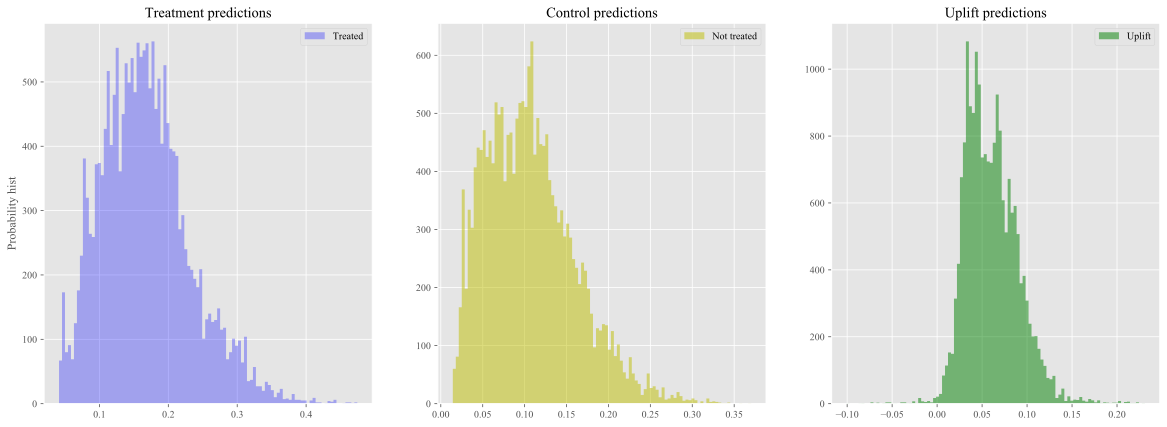

In [9]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=13, silent=True))
sm = sm.fit(X_train, y_train, X_train_treat)
uplift_sm = sm.predict(X_test)

sm_score10 = uplift_at_k(y_true=y_test, uplift=uplift_sm,
                       treatment=X_test_treat, strategy='by_group', k=0.1)
print(f'uplift@10%: {sm_score10:.4f}')
sm_score20 = uplift_at_k(y_true=y_test, uplift=uplift_sm,
                       treatment=X_test_treat, strategy='by_group', k=0.2)
print(f'uplift@20%: {sm_score20:.4f}')

models_results['uplift@10%'].append(sm_score10)
models_results['uplift@20%'].append(sm_score20)
models_results['model'].append('SoloModel')

# условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_
# распределениe вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [10]:
# ClassTransformation
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=13, silent=True))
ct = ct.fit(X_train, y_train, X_train_treat)

uplift_ct = ct.predict(X_test)
ct_score10 = uplift_at_k(y_true=y_test, uplift=uplift_ct,
                       treatment=X_test_treat, strategy='by_group', k=0.1)
print(f'uplift@10%: {ct_score10:.4f}')
ct_score20 = uplift_at_k(y_true=y_test, uplift=uplift_ct,
                       treatment=X_test_treat, strategy='by_group', k=0.2)
print(f'uplift@20%: {ct_score20:.4f}')

models_results['uplift@10%'].append(ct_score10)
models_results['uplift@20%'].append(ct_score20)
models_results['model'].append('ClassTransformation')

uplift@10%: 0.0932
uplift@20%: 0.0695


uplift@10%: 0.0988
uplift@20%: 0.0688


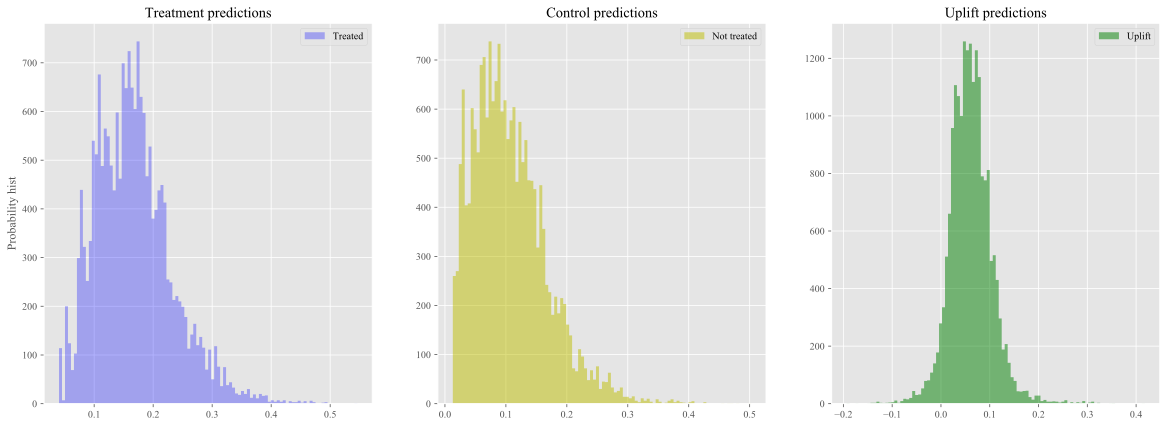

In [11]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=13, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=13, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, X_train_treat)

uplift_tm = tm.predict(X_test)

tm_score10 = uplift_at_k(y_true=y_test, uplift=uplift_tm,
                       treatment=X_test_treat, strategy='by_group', k=0.1)
print(f'uplift@10%: {tm_score10:.4f}')
tm_score20 = uplift_at_k(y_true=y_test, uplift=uplift_tm,
                       treatment=X_test_treat, strategy='by_group', k=0.2)
print(f'uplift@20%: {tm_score20:.4f}')

models_results['uplift@10%'].append(tm_score10)
models_results['uplift@20%'].append(tm_score20)
models_results['model'].append('TwoModels')
plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [12]:
result_data = pd.DataFrame(models_results)
result_data

,model,uplift@10%,uplift@20%
0,SoloModel,0.0823,0.0657
1,ClassTransformation,0.0932,0.0695
2,TwoModels,0.0988,0.0688


In [ ]:
# Некорректно работает, возникают сложности при установке и баги при работе(данная часть задания не выполнялась).
# %%time
# uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
#                                     n_reg=100, evaluationFunction='KL', control_name='control')

# uplift_model.fit(
#     X_train.values,
#     treatment=X_train_treat.map({1: 'treatment1', 0: 'control'}).values,
#     y=y_train)

# graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, X_train.columns)
# Image(graph.create_png())